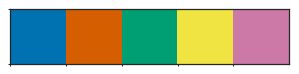

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn.algorithms import bootstrap
from seaborn.utils import ci as confidence_inv

sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

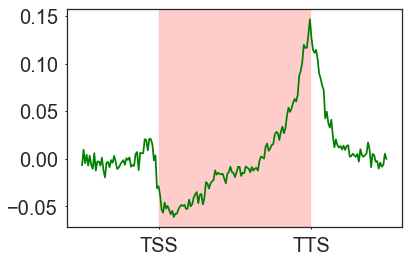

In [3]:
pol_ii_profiles = pd.read_table(
    ('/home/matthew/Documents/analysis_notebooks/'
     'tair10_gene_profiles/pol_ii_gene_profiles/'
     'tair_10_polii_geneprofile.profiles.tsv.gz'),
    sep='\t',
    index_col=0)
pol_ii_profiles.index = pol_ii_profiles.index.str.split('.', expand=True).get_level_values(0)
fig, ax = plt.subplots()
ax.plot(np.arange(200), pol_ii_profiles.mean(0), color='green')
ax.set(xticks=[50, 150],
       xticklabels=['TSS', 'TTS'])
ax.axvspan(50, 150, color='red', alpha=0.2)
plt.show()

In [65]:
%%bash
source activate ml_python35
g4seeqer -ts 0 -p 4 \
  -f /home/matthew/Documents/genomes/tair10/fasta/tair10_genome.fa \
  -b ./tair10_g4_g4seeqer.bed

2018-04-17 10:57:13.280845: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
Using TensorFlow backend.


In [69]:
%%bash
source activate cgat_python2

sort -k1,1 -k2,2n ./tair10_g4_g4seeqer.bed > ./tair10_g4_g4seeqer.sorted.bed

bedtools map -c 4 -o max -s -prec 2 -F 0.75 \
  -a /home/matthew/Documents/genomes/tair10/gff/araport11_genes.bed \
  -b ./tair10_g4_g4seeqer.sorted.bed > /tmp/g4seeqer_pos_max_score.bed

bedtools map -c 4 -o max -S -prec 2 -F 0.75 \
  -a /home/matthew/Documents/genomes/tair10/gff/araport11_genes.bed \
  -b ./tair10_g4_g4seeqer.sorted.bed > /tmp/g4seeqer_neg_max_score.bed

In [9]:
%%bash
source activate cgat_python2
g4predict intra \
  -f /home/matthew/Documents/genomes/tair10/fasta/tair10_genome.fa \
  -b /tmp/tair10_g4.bed \
  -s \
  -F \
  -tmin 2 \
  -tmax 2 \
  -lmin 1 \
  -lmax 7

INFO:root:Output from G4Predict
INFO:root:Parsing command line arguments
INFO:root:Running in mode: intra
INFO:root:Parameters:
{       'bed': '/tmp/tair10_g4.bed',
        'fasta': '/home/matthew/Documents/genomes/tair10/fasta/tair10_genome.fa',
        'filter_overlapping': True,
        'func': <function intra at 0x7f74a07a6c80>,
        'merge_overlapping': False,
        'write_bed12': False,
        'write_bed6': True}
INFO:root:G4 Parameters: 
{       'bulge_kwargs': {       'bulges_allowed': 0, 'start': 1, 'stop': 5},
        'inter_kwargs': {       'start': 2, 'stop': 3},
        'loop_kwargs_list': [       {       'allow_G': 1, 'start': 1, 'stop': 7},
                                    {       'allow_G': 1, 'start': 1, 'stop': 7},
                                    {       'allow_G': 1, 'start': 1, 'stop': 7}],
        'score_kwargs': {       'bulge_pen_factor': 5,
                                'loop_pen_factor': 1.5,
                                'tetrad_score_factor':

In [10]:
%%bash
source activate cgat_python2

bedtools makewindows \
  -g /home/matthew/Documents/genomes/tair10/tair10.chrom.sizes \
  -w 200 -s 25 -i srcwinnum | tee >(\
    awk -v OFS="\t" '{print $0 "_pos", ".", "+"}'  > /tmp/windows_pos.bed) | \
    awk -v OFS="\t" '{print $0 "_neg", ".", "-"}'  > /tmp/windows_neg.bed
cat /tmp/windows_pos.bed /tmp/windows_neg.bed | \
sort -k1,1 -k2,2n > /tmp/windows.bed

In [11]:
%%bash
source activate cgat_python2

bedtools map -c 4 -o count -s \
  -a /tmp/windows.bed \
  -b /tmp/tair10_g4.bed | \
awk -v OFS="\t" '{print $1, $2, $3, $4, $7, $6}' \
  > /tmp/g4_windowed_counts.bed

In [12]:
%%bash
source activate cgat_python2

bedtools map -c 5 -o max -s -prec 1 -F 0.75 \
  -a /home/matthew/Documents/genomes/tair10/gff/araport11_genes.bed \
  -b /tmp/g4_windowed_counts.bed > /tmp/g4_pos_maximal_density.bed

bedtools map -c 5 -o max -S -prec 1 -F 0.75 \
  -a /home/matthew/Documents/genomes/tair10/gff/araport11_genes.bed \
  -b /tmp/g4_windowed_counts.bed > /tmp/g4_neg_maximal_density.bed

In [71]:
colnames = ['chrom', 'start', 'end', 'gene_id', 'score', 'strand', 'max_g4seeqer_score']
converters = {'gene_id': str,
              'max_g4seeqer_score': lambda x: 0 if x == '.' else float(x)}
pos_g4seeqer = pd.read_csv('/tmp/g4seeqer_pos_max_score.bed',
                           sep='\t',
                           names=colnames,
                           converters=converters,
                           usecols=['gene_id', 'max_g4seeqer_score'])
neg_g4seeqer = pd.read_csv('/tmp/g4seeqer_neg_max_score.bed',
                           sep='\t',
                           names=colnames,
                           converters=converters,
                           usecols=['gene_id', 'max_g4seeqer_score'])

g4seeqer_score = pos_g4seeqer.merge(neg_g4seeqer,
                                    on='gene_id',
                                    suffixes=('_coding', '_template'))
g4seeqer_score = g4seeqer_score.set_index('gene_id')
g4seeqer_score.head()                          

,max_g4seeqer_score_coding,max_g4seeqer_score_template
gene_id,,
AT1G01010,0.094,0.034
AT1G01020,0.043,0.000
AT1G03987,0.000,0.000
AT1G01030,0.620,0.130
AT1G01040,0.140,0.026


In [106]:
colnames = ['chrom', 'start', 'end', 'gene_id', 'score', 'strand', 'max_g4_density']
converters = {'gene_id': str,
              'max_g4_density': lambda x: 0 if x == '.' else round(float(x))}
pos_g4_density = pd.read_csv('/tmp/g4_pos_maximal_density.bed',
                             sep='\t',
                             names=colnames,
                             converters=converters,
                             usecols=['gene_id', 'max_g4_density'])
neg_g4_density = pd.read_csv('/tmp/g4_neg_maximal_density.bed',
                             sep='\t',
                             names=colnames,
                             converters=converters,
                             usecols=['gene_id', 'max_g4_density'])

g4_max_density = pos_g4_density.merge(neg_g4_density,
                                      on='gene_id',
                                      suffixes=('_coding', '_template'))
g4_max_density = g4_max_density.set_index('gene_id')
g4_max_density.head()                          

,max_g4_density_coding,max_g4_density_template
gene_id,,
AT1G01010,1,1
AT1G01020,0,0
AT1G03987,0,0
AT1G01030,0,1
AT1G01040,1,1


In [15]:
g4 = g4seeqer_score.join(g4_max_density)

In [16]:
%%bash
awk '$3 == "gene"' /home/matthew/Documents/genomes/tair10/gff/tair10_no_mt_pt_transposon.gtf | \
grep 'gene_biotype "protein_coding"' | \
awk '{print $10}' | \
sed 's/[;"]//g' > ./tair10_prot_coding.txt

In [72]:
prot_coding_genes = !cat ./tair10_prot_coding.txt
prot_coding_genes = [x.strip() for x in prot_coding_genes]

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  app.launch_new_instance()
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()


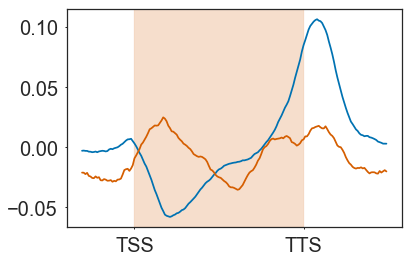

In [73]:
fig, ax = plt.subplots()
prot_coding = pol_ii_profiles.index.isin(prot_coding_genes)
ax.plot(np.arange(200), pd.rolling_mean(pol_ii_profiles[prot_coding].mean(0), 20), color=pal[0])
ax.plot(np.arange(200), pd.rolling_mean(pol_ii_profiles[~prot_coding].mean(0), 20), color=pal[1])
ax.set(xticks=[50, 150],
       xticklabels=['TSS', 'TTS'])
ax.axvspan(50, 150, color=pal[1], alpha=0.2)
plt.show()

In [74]:
pol_ii_profiles_prot_coding = pol_ii_profiles[prot_coding]

In [91]:
x = bootstrap(pol_ii_profiles_prot_coding.values, n_boot=5, func=lambda arr: np.mean(arr, axis=0))

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


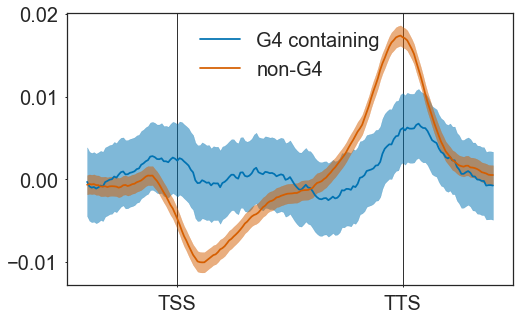

In [113]:
def bootstrap_rolling_mean(data, n_boot=1000, win=20, ci=68):
    samples = bootstrap(data, n_boot=n_boot, func=lambda arr: np.mean(arr, axis=0))
    samples = np.transpose(samples.T / np.abs(samples).sum(1))
    ci = confidence_inv(samples, ci, axis=0)
    ci = pd.rolling_mean(ci, window=win, center=True, axis=1)
    central_data = pd.rolling_mean(samples.mean(0), window=win, center=True)
    return central_data, ci

g4_gene_idx = pol_ii_profiles_prot_coding.index.isin(g4seeqer_score[g4seeqer_score.max_g4seeqer_score_template > 0.9].index)
non_g4_gene_idx = pol_ii_profiles_prot_coding.index.isin(g4seeqer_score[g4seeqer_score.max_g4seeqer_score_template < 0.1].index)
g4_mean, g4_ci = bootstrap_rolling_mean(pol_ii_profiles_prot_coding[g4_gene_idx])
non_g4_mean, non_g4_ci = bootstrap_rolling_mean(pol_ii_profiles_prot_coding[non_g4_gene_idx])
fig, ax = plt.subplots(figsize=(8, 5))
ax.fill_between(np.arange(200), *g4_ci, color=pal[0], alpha=0.5)
ax.plot(g4_mean, color=pal[0], label='G4 containing')
ax.fill_between(np.arange(200), *non_g4_ci, color=pal[1], alpha=0.5)
ax.plot(non_g4_mean, color=pal[1], label='non-G4')
ax.set(xticks=[50, 150],
       xticklabels=['TSS', 'TTS'])
ax.axvline(50, alpha=1, zorder=0, color='k', linewidth=0.8)
ax.axvline(150, alpha=1, zorder=0, color='k', linewidth=0.8)
plt.legend(loc=9)
plt.savefig('./polii_occupancy_g4seeqer.svg')
plt.show()

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


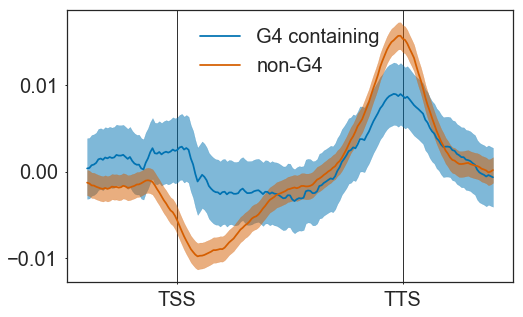

In [114]:
g4_gene_idx = pol_ii_profiles_prot_coding.index.isin(g4_max_density[g4_max_density.max_g4_density_template > 3].index)
non_g4_gene_idx = pol_ii_profiles_prot_coding.index.isin(g4_max_density[g4_max_density.max_g4_density_template == 0].index)
g4_mean, g4_ci = bootstrap_rolling_mean(pol_ii_profiles_prot_coding[g4_gene_idx])
non_g4_mean, non_g4_ci = bootstrap_rolling_mean(pol_ii_profiles_prot_coding[non_g4_gene_idx])
fig, ax = plt.subplots(figsize=(8, 5))
ax.fill_between(np.arange(200), *g4_ci, color=pal[0], alpha=0.5)
ax.plot(g4_mean, color=pal[0], label='G4 containing')
ax.fill_between(np.arange(200), *non_g4_ci, color=pal[1], alpha=0.5)
ax.plot(non_g4_mean, color=pal[1], label='non-G4')
ax.set(xticks=[50, 150],
       xticklabels=['TSS', 'TTS'])
ax.axvline(50, alpha=1, zorder=0, color='k', linewidth=0.8)
ax.axvline(150, alpha=1, zorder=0, color='k', linewidth=0.8)
plt.legend(loc=9)
plt.savefig('./polii_occupancy_max_g4_density.svg')
plt.show()